In [1]:
# import libary
import numpy as np  
import numpy.linalg  as lg

import matplotlib
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from IPython.display import clear_output

from scipy.optimize import minimize,Bounds

In [2]:
class DataGenerator:   
    
    def __init__(self,
                 sample_size,
                 data_type = "GP",fixed_effect_type = "linear",
                 const_factor = 1):
        
        FIXED_EFF_LIST = ["hajjem","friedman","linear"]
        DATA_TYPE_LIST = ["GP","GRF"]
        
        
        if data_type not in DATA_TYPE_LIST:
            print("wrong data_type, only allow:", DATA_TYPE_LIST)
            return
        
        if fixed_effect_type not in FIXED_EFF_LIST:
            print("wrong fixed_effect_type, only allow:", FIXED_EFF_LIST)
            return
        self.N = sample_size
        self.ref_scale = -1
        self.data_type = data_type
        self.fixed_effect_type = fixed_effect_type
        self.C = const_factor
        self.theta = []
        self.X = None
        self.y = None
        self.s = None
        
    def set_parameter(self,sigsq_1,sigsq_e,rho = -0.1):
        if self.data_type == "GP":
            if rho == -0.1:
                print("need more parameter input, expect rho")
                return
            self.theta = [sigsq_1,sigsq_e,rho ]
        else:
            self.theta = [sigsq_1,sigsq_e]
            
            
    def fix_effect(self,N,C,mode):
        if mode == 'hajjem':
            X = np.random.normal(size = (N,9))
            hajjem = lambda x1,x2,x3,C:C*(2*x1 +x2**2 +4*(x3>0)+2*x3*np.log(abs(x1)))
            return X, hajjem(X.T[0],X.T[1],X.T[2],C)
        elif mode == 'friedman':
            x1 = np.random.uniform(0,100,size = N)
            x2 = np.random.uniform(40*np.pi,100*np.pi,size = N)
            x3 = np.random.uniform(0,1,size = N)
            x4 = np.random.uniform(1,11,size = N)
            X= np.array([x1,x2,x3,x4]).T
            friedman = lambda x1,x2,x3,x4,C:C*np.arctan((x2*x3-1-1/(x2*x4))/x1)
            return X,friedman(x1,x2,x3,x4,C)        
        elif mode == 'linear':
            x1,x2 =np.random.uniform(size = N),np.random.uniform(size = N)
            X= np.array([x1,x2]).T
            linear = lambda x1,x2,C: C*(1+x1+x2)
            return X,linear(x1,x2,C)
        
    def Cov(self,s,sigsq_1,rho):
        Cov = []
        K=self.ref_scale
        for i in range(K):
            covbi = []
            for j in range(K):
                covbi += [sigsq_1*np.exp(-(s[i]-s[j])**2/rho**2)]
            Cov += [covbi]
        return np.array(Cov)
    
    def Generate(self,Z,
                  slb=0, sub = 100, s_type = "uniform"):
        s_INDEX_LIST = ["uniform", "linespace"]
        self.ref_scale = len(Z.T)
        K = self.ref_scale
        fmode = self.fixed_effect_type
        X, fixed_effect = self.fix_effect(self.N,self.C,fmode)
        
        if self.data_type == "GEF":
            sigsq_1,sigsq_err = self.theta[0],self.theta[1]        
            b =  np.random.normal(0,sigsq_1,size = self.ref_scale)
            err = np.random.normal(0,sigsq_err,size = self.N )
            y  = fixed_effect + Z@b + err
            self.X = X
            self.y = y
        
        elif self.data_type == "GP":
            sigsq_1,rho,sigsq_err = self.theta[0],self.theta[1],self.theta[2]
            if s_type not in s_INDEX_LIST :
                print("wrong input for s_type, only allow:", s_INDEX_LIST)
            elif s_type == "uniform":
                s = np.random.uniform(slb,sub,size = K)
            elif s_type == "linespace":           
                s = np.linspace(slb,sub,size = K)
            Cov = self.Cov(s, sigsq_1,rho)           
            b = np.random.multivariate_normal(np.zeros(K),Cov)
            err = np.random.normal(0,sigsq_err,size = self.N)           
            y  = fixed_effect + Z@b + err
            self.X = X
            self.y = y
            self.s = s
        else:
            print("Fail to fit")
                

In [3]:
class GPB_Regressor:
    
    def __init__(self,
                 learning_rate = 1,
                 max_depth = 2, min_sample_leaf = 2):
        self.X = None
        self.y = None
        self.Z = None
        self.s = None
        self.Classifier = []
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_sample_leaf = min_sample_leaf
        self.current_Phi_inv = None
        self.parameter = None
        self.theta_record =[]
        self.neg_ll_record = []
        self.train_err_record = []
    
    class Vecchia_Approx:
        
        def __init__ (self, 
                      Z,s,theta,mv=10):
            
            self.Z = Z
            self.s = np.array(s)
            self.mv = mv
            self.Sig = GPB_Regressor().Cov(s, theta[0],theta[1])
            self.ZSigZ = Z@self.Sig@Z.T
            self.Phi = self.ZSigZ +theta[2]*np.identity(N)
            self.N_list = []
            self.A_list = []
            self.B_arr = None
            self.D_list = []
            self.run_apprximation()
            self.VA_B_Generator()
        
        def VA_B_Generator(self):
    
            N = len(self.Z)
            B_arr = np.identity(N)

            for i in range(N):
                if i==0:
                    continue
                p=0
                for j in self.N_list[i]:
                    if j >= i:
                        p+=1
                        continue
                    else:
                        B_arr[i][j] = -self.A_list[i][p]
                        p+=1 
            self.B_arr = B_arr
            
        def run_apprximation(self):
            
            N =len(self.Z)
            # Generate Nlist
            for i in range(N):      
                if i+1 <= self.mv+1:
                    if len(range(0,i)) == 0:
                        ni = np.array(-1)
                    else:
                        ni = np.array(range(0,i))
                else:
                    si = self.s[i]
                    si_dist = (self.s -si)**2
                    ni = np.argsort(si_dist)[1:self.mv+1]
                # generate A,D
                if np.array(-1) in ni:
                    Ai = 0
                    Di = self.Phi[i][i]  
                else:
                    #print(i,N_list[i], np.shape(Phi[N_list[i]].T[N_list[i]]))
                    Ai = self.ZSigZ[i][ni]@ lg.inv(self.Phi[ni].T[ni])
                    Di = self.Phi[i][i] - Ai @ self.ZSigZ[ni].T[i]                    
                    
                # update N,A,D    
                self.N_list+=[ni]
                self.A_list+=[Ai]
                self.D_list +=[Di]
                
    
      
    def data_fit(self, X,y,Z,s):
        
        if len(X) != len(y):
            print("Size X: ",len(X),"does not fit size y: ", len(y))
            return
        if len(Z) != len(y):
            print("Size Z: ",len(Z),"does not fit size X/y: ", len(y))
        if len(Z.T) != len(s):
            print("Z.T scale",len(Z.T),"does not fit s scale:",len(s))        
        self.X = X
        self.y = y
        self.Z = Z
        self.s = s              
        
    def Cov(self,s, sigsq_1,rho, sp = [],Op = False):
               
        K = len(s)
        Cov = []
        if Op == True and len(sp) == len(s):
            for i in range(K):
                covbi = []
                for j in range(K):
                    covbi += [sigsq_1*np.exp(-(s[i]-sp[j])**2/rho**2)]
                Cov += [covbi]
        else:
            for i in range(K):
                covbi = []
                for j in range(K):
                    covbi += [sigsq_1*np.exp(-(s[i]-s[j])**2/rho**2)]
                Cov += [covbi]
        return np.array(Cov)   

    def negll_GP(self, theta, FX):
        y,Z,s = self.y,self.Z,self.s
        N,K = len(y),len(Z.T)
        sigsq_1,rho,sigsq_e = theta[0],theta[1],theta[2]        
        Sig = self.Cov(s, sigsq_1,rho)
        Phi = Z@Sig@Z.T +sigsq_e*np.identity(N)
        Phi_inv = lg.inv(Phi)
        Phi_det = lg.det(Phi)
        #print(Phi_det)
        return (y-FX).T@Phi_inv@(y-FX) +np.log(Phi_det)
    
    def Boosting_update(self, Phi_inv,FmX, mode, D_list = []):
    
        fm = DecisionTreeRegressor(max_depth = self.max_depth, 
                                   min_samples_leaf =self.min_sample_leaf)
        if mode == 'GB':
            fm.fit(self.X, Phi_inv @(self.y-FmX))       
        elif mode =='NB':
            fm.fit(self.X ,self.y -FmX, sample_weight = D_list)
        elif mode == 'HGNB':
              fm.fit(self.X, Phi_inv @(self.y-FmX),sample_weight = D_list) 
        else:
            print('wrong mode input')
        
        return fm

    def Fixed_Effect_Pred(self,X, Classifier):
        M = len(Classifier)
        pred_step = Classifier[0].predict(X)
        for m in range(M):
            if m == 0:
                continue
            pred_step += self.learning_rate*Classifier[m].predict(X)
        return pred_step
    
    def stepwise_pred(self,X_pred,Z_pred,s_pred):
        M = len(self.Classifier)
        stepwise_pred = []
        for m in range (M):
            stepwise_pred +=[self.predict(X_pred,Z_pred,s_pred,
                                          Classifier =self.Classifier[:m+1])]
        return np.array(stepwise_pred)
                
    
    def predict(self,X_pred,Z_pred,s_pred, Classifier = -1):
        if Classifier == -1:
            Classifier = self.Classifier
        N = len(self.y) 
        Np = len(X_pred)
        sigsq_1,sigsq_e = self.parameter[0],self.parameter[2]
        rho = self.parameter[1]
        Sig = self.Cov(self.s, sigsq_1,rho)
        Sig_p = self.Cov(s_pred, sigsq_1,rho)
        Sig_op = self.Cov(s_pred, sigsq_1,rho, sp = self.s,Op = True)
 
        FX_pred = self.Fixed_Effect_Pred(X_pred, Classifier)
        FX_obs = self.Fixed_Effect_Pred(self.X, Classifier)
        Phi_inv = lg.inv(self.Z@Sig@self.Z.T + sigsq_e*np.identity(N))
        return FX_pred + (self.Z@Sig@self.Z.T +Z_pred@Sig_op@self.Z.T)@Phi_inv@(self.y-FX_obs)
    
    
    def fit(self,X,y,Z,s,
            theta_ini = np.ones(3),            
            boosting_mode = "GB",NesterovAccel = False,
            max_iteration = 1000, VA_option = True,tol = 1e-10):
        
        Boost_MODE_LIST = ["GB", "NB","HGNB"]
        if boosting_mode not in Boost_MODE_LIST:
            print("Wrong mode input,Input: \"GB\" = Gradient Boosting",
                  "\"NB\" = Newton Boosting",
                  ", \"HGNB\" = Hybrid Gradient Newton Boosting")
        
        # fit data into class 
        self.data_fit(X,y,Z,s)
        self.parameter = np.ones(3)
        self.theta_record +=[theta_ini]
        
        F_lastupate = DecisionTreeRegressor(max_depth = self.max_depth, 
                                min_samples_leaf =self.min_sample_leaf)
    
        F_lastupate.fit(X,y)
        self.Classifier = [F_lastupate]
        Current_FX = F_lastupate.predict(X)
        bds = Bounds([1e-10,-np.inf,1e-10], 
                     [np.inf,np.inf ,np.inf], keep_feasible=True)
        
        for m in range(max_iteration):
            # update estimator
            
            estimator_update = minimize(self.negll_GP, 
                                        theta_ini,args= Current_FX, 
                                        
                                        bounds = bds,tol=0.01)            
            theta_new = estimator_update.x
            self.theta_record +=[theta_new]
            self.parameter = theta_new
            negll = self.negll_GP(theta_new, Current_FX)
            
            if NesterovAccel:
                print("haven't develope NestrovAccel case yet")
                                
            Sig = self.Cov(s,theta_new[0],theta_new[1])
            Phi = self.Z@Sig@self.Z.T +theta_new[2]*np.identity(N)
            self.current_Phi_inv = lg.inv(Phi)
            
            if boosting_mode != Boost_MODE_LIST[0]:
                if VA_option == True :
                    VA = self.Vecchia_Approx(self.Z,self.s,theta_new)
                    Dl = VA.D_list/sum(VA.D_list)
                else:
                    Dl = np.ones(N)/N
                F_lastupate = self.Boosting_update(lg.inv(Phi), Current_FX, 
                                           boosting_mode,Dl)
            else:
                F_lastupate = self.Boosting_update(lg.inv(Phi), 
                                                   Current_FX,boosting_mode)
            if lg.det(self.current_Phi_inv) <0:
                print("non PSD Phi observed, early terminate, current itertation: ",m)
                return
                
            # update paremeters
            self.Classifier += [F_lastupate]        
            Current_FX = self.Fixed_Effect_Pred(self.X, Classifier=self.Classifier)
            
            self.neg_ll_record += [(negll+self.negll_GP(theta_new, Current_FX))/2]
            
            yhat = self.predict(self.X,self.Z,self.s, 
                                Classifier=self.Classifier)
            self.train_err_record += [np.mean((y-yhat)**2)]
            '''if abs(self.neg_ll_record[-1]-self.neg_ll_record[-1])<tol:
                return'''
            clear_output()
            print('finished ',m+1,'th iteration')
        return



In [ ]:
class MEF_Regressor:
    
    def __init__(self,
                 learning_rate = 1,
                 max_depth = 2, min_sample_leaf = 2):
        self.X = None
        self.y = None
        self.Z = None
        self.Classifier = []
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_sample_leaf = min_sample_leaf
        self.parameter = None
        self.theta_record =[]
        self.neg_ll_record = []
        self.train_err_record = []
        
        
    def data_fit(self, X,y,Z):
        
        if len(X) != len(y):
            print("Size X: ",len(X),"does not fit size y: ", len(y))
            return
        if len(Z) != len(y):
            print("Size Z: ",len(Z),"does not fit size X/y: ", len(y))       
        self.X = X
        self.y = y
        self.Z = Z
    
    
    def negll_ME(self, theta, FX):
        y,Z,s = self.y,self.Z,self.s
        N,K = len(y),len(Z.T)
        sigsq_1,sigsq_e = self.parameter[0],self.parameter[1]       
        Phi = sigsq_1*Z@Z.T +sigsq_e*np.identity(N)
        Phi_inv = lg.inv(Phi)
        Phi_det = lg.det(Phi)
        #print(Phi_det)
        return (y-FX).T@Phi_inv@(y-FX) +np.log(Phi_det)
    
    def GEF_estimator(self,FX):
        y,Z = self.y,self.Z
        N = len(y)
        K = Z@Z.T
        A = np.zeros(shape=(N,N))
        for i in range(N):
            A[i] = (y-FX)*(y[i]-FX[i])
        denominator =  N*np.trace(K@K.T) - np.trace(K)**2
        sigsq_1_new = (N*np.trace(K@A.T) - np.trace(K)*np.trace(A))/denominator
        sigsq_e_new = (np.trace(K@K.T)*np.trace(A) - 
                       np.trace(K@A.T)*np.trace(K))/denominator
        return np.array([sigsq_1_new,sigsq_e_new])
    
    def Boosting_update(self, Phi_inv,FmX, mode, D_list = np.ones(len(self.y))/N):
    
        fm = DecisionTreeRegressor(max_depth = self.max_depth, 
                                   min_samples_leaf =self.min_sample_leaf)
        if mode == 'GB':
            fm.fit(self.X, Phi_inv @(self.y-FmX))       
        elif mode =='NB':
            fm.fit(self.X ,self.y -FmX, sample_weight = D_list)
        elif mode == 'HGNB':
              fm.fit(self.X, Phi_inv @(self.y-FmX),sample_weight = D_list) 
        else:
            print('wrong mode input')
            
    def Fixed_Effect_Pred(self,X, Classifier):
        M = len(Classifier)
        pred_step = Classifier[0].predict(X)
        for m in range(M):
            if m == 0:
                continue
            pred_step += self.learning_rate*Classifier[m].predict(X)
        return pred_step
    
    def fit(self,X,y,Z,
            theta_ini = np.ones(2),            
            boosting_mode = "GB",max_iteration = 1000 ):
        
        Boost_MODE_LIST = ["GB", "NB","HGNB"]
        if boosting_mode not in Boost_MODE_LIST:
            print("Wrong mode input,Input: \"GB\" = Gradient Boosting",
                  "\"NB\" = Newton Boosting",
                  ", \"HGNB\" = Hybrid Gradient Newton Boosting")
        
        # fit data into class 
        self.data_fit(X,y,Z)
        self.parameter = theta_ini
        self.theta_record +=[theta_ini]
        
        F_lastupate = DecisionTreeRegressor(max_depth = self.max_depth, 
                                min_samples_leaf =self.min_sample_leaf)
    
        F_lastupate.fit(X,y)
        self.Classifier = [F_lastupate]
        Current_FX = F_lastupate.predict(X)
        
        
        for m in range(max_iteration):
            negll = self.negll_ME(self.parameter,Current_FX)
            Phi = self.parameter[0]*Z@Z.T +self.parameter[1]*np.identity(N)
            F_lastupate = self.Boosting_update(X,y,lg.inv(Phi), Current_FX,
                                          Boosting_mode_list[Boosting_mode])
            self.Classifier +=[F_lastupate]

            Current_FX = self.Fixed_Effect_Pred(X,self.Classifier)
            self.neg_ll_record += [[negll,self.negll_ME(self.parameter,Current_FX)]]
        
            self.parameter = self.GEF_estimator(Current_FX)
            self.theta_record += [self.parameter]
       
            print('finished ',m+1,'th loop')
    

### Simulation

Fixed Effect = hajjem

In [5]:
N = 100
Z = np.identity(N)
sigsq1,rho,sigsqe = 4,2,2
FIXED_EFF_LIST = ["hajjem","friedman","linear"]
Boost_MODE_LIST = ["GB", "NB","HGNB"]
GP_Data = DataGenerator(N, data_type = "GP",fixed_effect_type = FIXED_EFF_LIST[0])
GP_Data.set_parameter(sigsq1,rho,sigsqe)
GP_Data.Generate(Z)
GP_Data_test= DataGenerator(N, data_type = "GP",fixed_effect_type = FIXED_EFF_LIST[0])
GP_Data_test.set_parameter(sigsq1,rho,sigsqe)
GP_Data_test.Generate(Z)

In [8]:
gpb_list = []
learning_rate_list = [1,0.1]
max_depth_list = [1,5]
Boost_MODE_LIST = ["GB", "NB","HGNB"]

for i in learning_rate_list:
    gpbi = []
    for j in max_depth_list:
        gpbij = []
        for k in Boost_MODE_LIST:
            gpb = GPB_Regressor(learning_rate = i,max_depth = j)
            gpb.fit(GP_Data.X,GP_Data.y,Z,GP_Data.s,
                    boosting_mode = k,max_iteration = 200)
            gpbij += [gpb]
            print("Finished lr = ",i,"\t Max_depth =", j ,"Boosting_Mode = ", k)
        gpbi+=[gpbij]
    gpb_list += [gpbi]
            

finished  200 th iteration
Finished lr =  0.1 	 Max_depth = 5 Boosting_Mode =  HGNB


In [10]:
test_err,train_err = [],[]

for i in range(2):
    testi,tri = [],[]
    for j in range(2):
        testij,trij = [],[]
        for k in range(3):
            trij += [gpb_list[i][j][k].train_err_record]
            y_test_pred = gpb_list[i][j][k].stepwise_pred(GP_Data_test.X,
                                                          Z,GP_Data_test.s)
            testij += [np.mean((y_test_pred - GP_Data_test.y)**2,axis = 1)]
            #print("Finished lr = ",i,"\t Max_depth =", j ,"Boosting_Mode = ", k)
        testi +=[testij]
        tri += [trij]
    test_err += [testi]
    train_err += [tri]

Finished lr =  0 	 Max_depth = 0 Boosting_Mode =  0
Finished lr =  0 	 Max_depth = 0 Boosting_Mode =  1
Finished lr =  0 	 Max_depth = 0 Boosting_Mode =  2
Finished lr =  0 	 Max_depth = 1 Boosting_Mode =  0
Finished lr =  0 	 Max_depth = 1 Boosting_Mode =  1
Finished lr =  0 	 Max_depth = 1 Boosting_Mode =  2
Finished lr =  1 	 Max_depth = 0 Boosting_Mode =  0
Finished lr =  1 	 Max_depth = 0 Boosting_Mode =  1
Finished lr =  1 	 Max_depth = 0 Boosting_Mode =  2
Finished lr =  1 	 Max_depth = 1 Boosting_Mode =  0
Finished lr =  1 	 Max_depth = 1 Boosting_Mode =  1
Finished lr =  1 	 Max_depth = 1 Boosting_Mode =  2


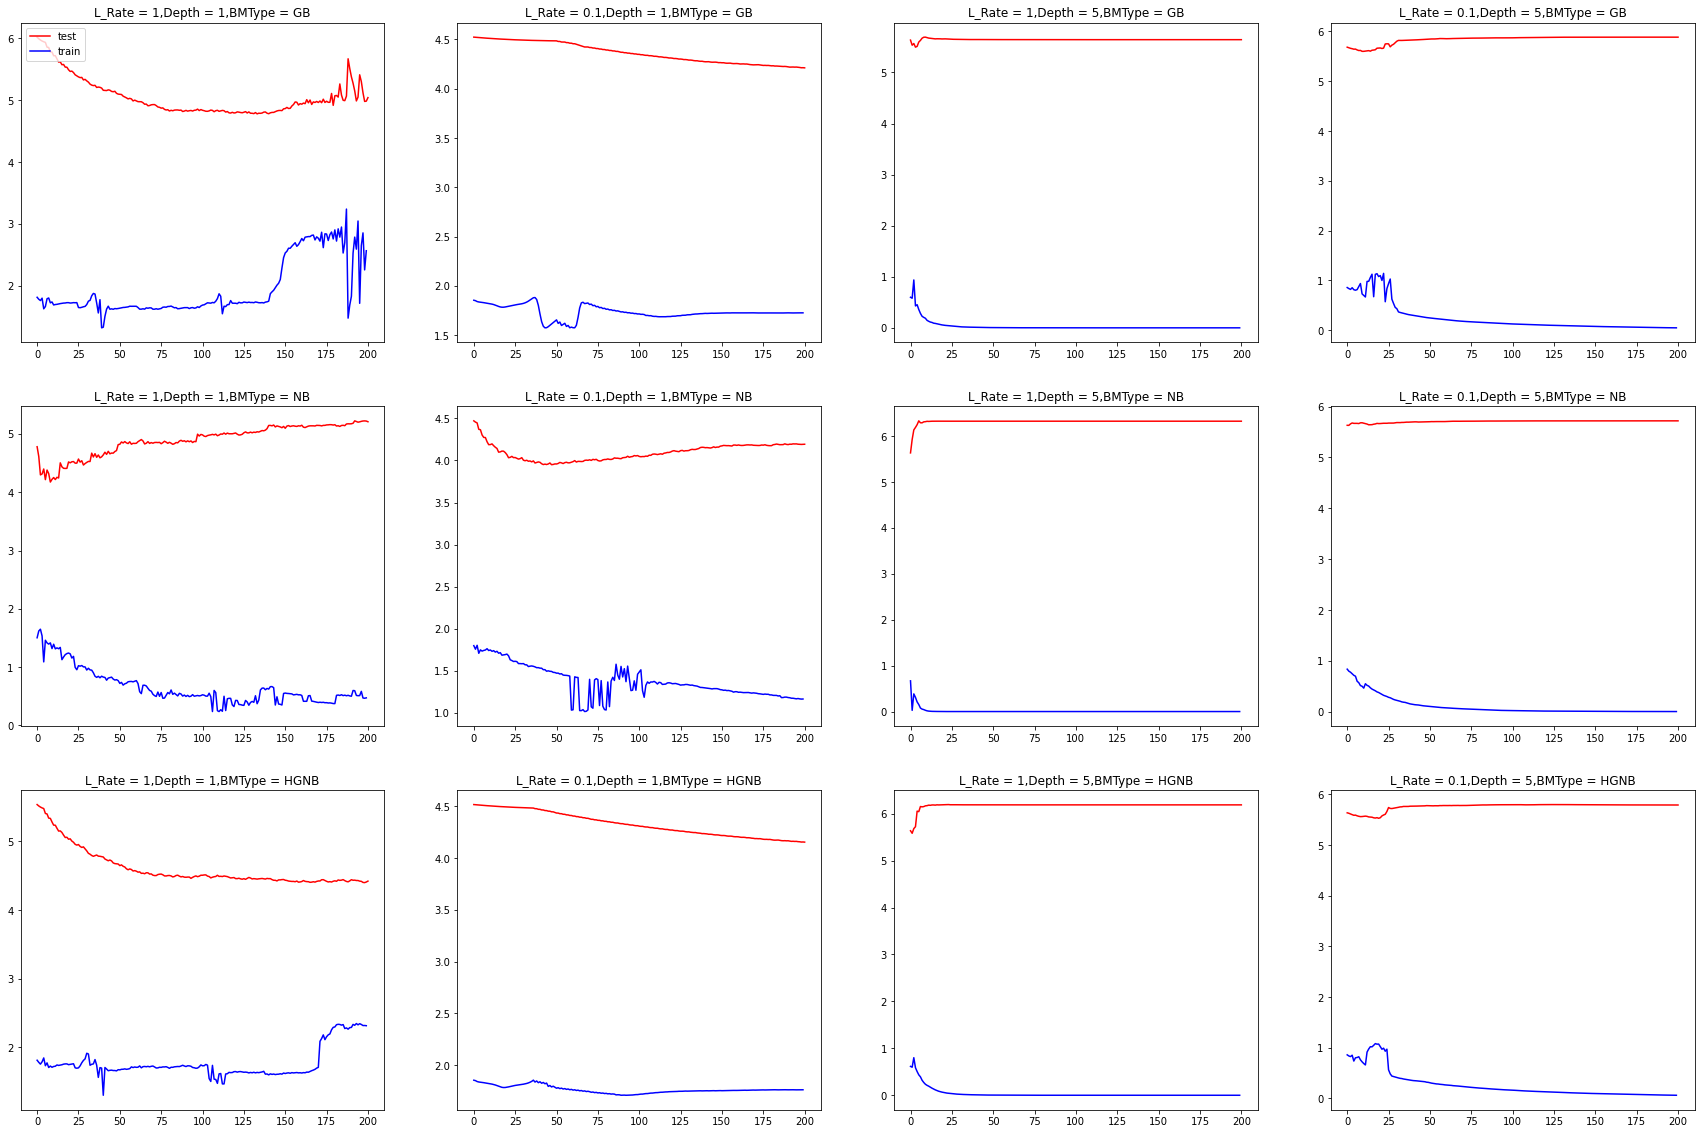

In [24]:
f, ax = plt.subplots(3,4)
k = 1
f.set_figheight(20)
f.set_figwidth(30)
for i in range(2):
    for j in range(2):
        for k in range(3):
            ax[k][i+2*j].plot(np.sqrt(test_err[i][j][k]),c = 'red')
            ax[k][i+2*j].plot(np.sqrt(train_err[i][j][k]),c = 'blue')
            title = 'L_Rate = '+str(learning_rate_list[i])+',Depth = '+str(max_depth_list[j])+',BMType = '+str(Boost_MODE_LIST[k])
            ax[k][i+2*j].title.set_text(title)
ax[0][0].legend(["test" ,"train"], loc = "upper left")

plt.show()